In [16]:
import numpy as np
import pandas as pd
import os
import time
import pydicom as dicom
import pydicom
import matplotlib.pyplot as plt
import json
import glob
import collections
#from pydicom.pixel_data_handlers.util import apply_voi_lut
#import cv2
#from skimage import measure
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
from glob import glob
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [17]:
train_series = pd.read_csv('data/train_series_descriptions.csv')
df_train = pd.read_csv('data/train.csv')
test_series = pd.read_csv('data/test_series_descriptions.csv')

### Display Sample Images

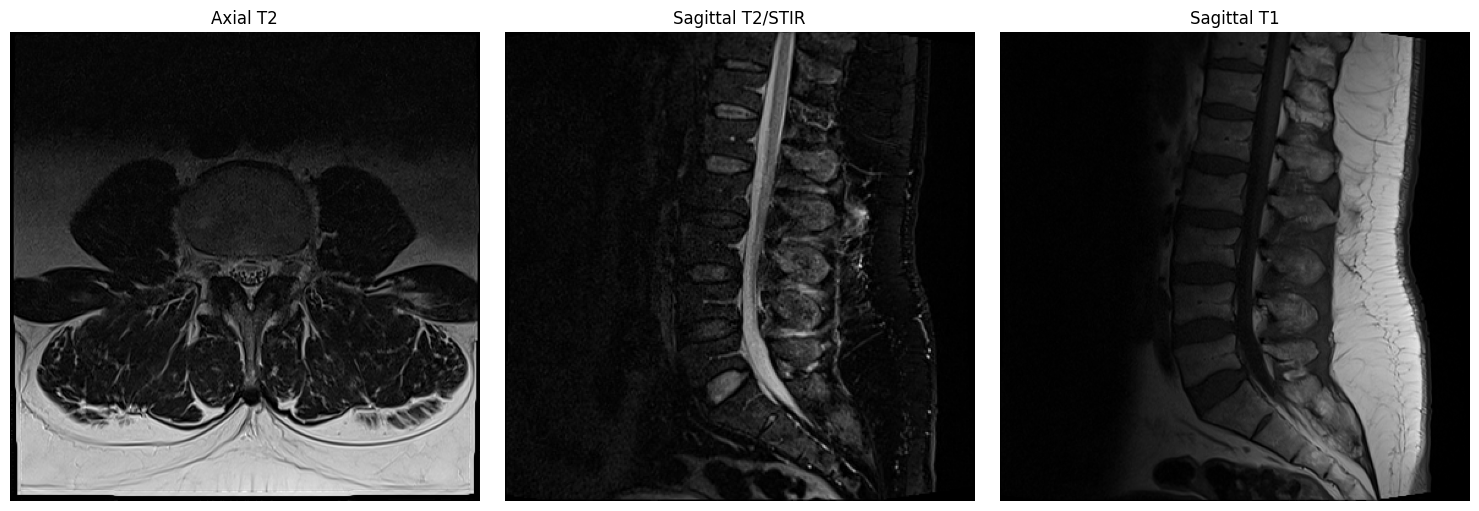

In [18]:
folder_path = 'images/train_images/7143189'

study_id = folder_path.split('/')[-2]
series_ids = [f for f in os.listdir(folder_path)]
dicom_files = {}
for series in series_ids:
    image = os.listdir(f"{folder_path}/{series}")[8]
    dicom_files[series] = image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
types = ["Axial T2", "Sagittal T2/STIR", "Sagittal T1"]

for i, (series, dicom_file) in enumerate(dicom_files.items()):
    dicom_file_path = os.path.join(folder_path, series, dicom_file)
    dicom_data = pydicom.dcmread(dicom_file_path)
    image = dicom_data.pixel_array   
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(types[i])
    axs[i].axis('off')   

plt.tight_layout()
plt.show()

### Subset Data

In [19]:
df_train

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [20]:
train_series

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [21]:
test_series

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


Training data: 1975 studies, predict 25 target columns<br>
Testing data: 3 studies, predict 25 target columns<br>
Each study has 3 series (Sagittal T2, Sagittal T1, Axial T2)

### Subset Data & Images

In [22]:
grouped = {}
unique_scans = train_series["series_description"].unique()

for scan in unique_scans:
    grouped[scan] = train_series[train_series['series_description'] == scan]

sagittal_t1_df = grouped["Sagittal T1"]
sagittal_t2_df = grouped["Sagittal T2/STIR"]
axial_t2_df = grouped["Axial T2"]

In [23]:
def load_images(df):
    images = {}
    for _, row in df.iterrows():
        folder_path = f'images/train_images/{row['study_id']}/{row['series_id']}'
        dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
        for dicom_file in dicom_files:
            dicom_file_path = os.path.join(folder_path, dicom_file)
            dicom_data = pydicom.dcmread(dicom_file_path)
            image = dicom_data.pixel_array      # image size: 384x384
            image = image / 255.0               # normalize pixel values
            images[row['study_id']] = image
    return images

In [ ]:
sagittal_t1_images = load_images(sagittal_t1_df)
sagittal_t2_images = load_images(sagittal_t2_df)
axial_t2_images = load_images(axial_t2_df)

In [25]:
sagittal_t1_images

{4003253: array([[0.00784314, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
         0.        ],
        [0.00392157, 0.01176471, 0.01176471, ..., 0.        , 0.        ,
         0.        ],
        [0.00392157, 0.01568627, 0.01568627, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00784314, 0.01568627, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        [0.00784314, 0.01960784, 0.01568627, ..., 0.        , 0.        ,
         0.        ],
        [0.00784314, 0.00784314, 0.00784314, ..., 0.        , 0.        ,
         0.        ]]),
 4646740: array([[0.01176471, 0.00784314, 0.00392157, ..., 0.        , 0.        ,
         0.        ],
        [0.01568627, 0.04705882, 0.05882353, ..., 0.        , 0.        ,
         0.        ],
        [0.01568627, 0.03529412, 0.03921569, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01176471, 0.0745098 , 0.05490196, ..., 0.        , 0.        ,
         0.     

### Prepare X and Y

In [ ]:
# Label Encoding for target vars
labels = {"Normal/Mild": 0, "Moderate": 1, "Severe": 2}

for col in df_train.columns[1:]:
    df_train[col] = df_train[col].map(labels)

df_train

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4646740,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0
2,7143189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8785691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10728036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1971,4283570761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1972,4284048608,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
1973,4287160193,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
X_sagittal_t1, Y_sagittal_t1 = [], []
X_sagittal_t2, Y_sagittal_t2 = [], []
X_axial_t2, Y_axial_t2 = [], []

for i, row in df_train.iterrows():
    study_id = row["study_id"]

    if study_id in sagittal_t2_images:
        X_sagittal_t1.append(sagittal_t1_images[study_id])
        Y_sagittal_t1.append((row.iloc[1:]).values)

    if study_id in sagittal_t2_images:
        X_sagittal_t2.append(sagittal_t2_images[study_id])
        Y_sagittal_t2.append((row.iloc[1:]).values)

    if study_id in axial_t2_images:
        X_axial_t2.append(axial_t2_images[study_id])
        Y_axial_t2.append((row.iloc[1:]).values)